<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

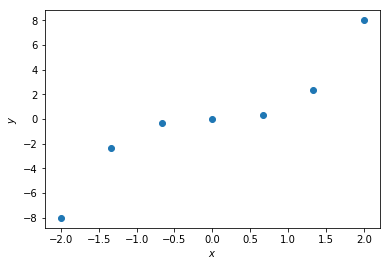

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [4]:
# Должен получиться 0))
round(sum(y), 4)

-0.0

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [5]:

s1 = [yy for yy in y if yy < 0]  
s2 = [yy for yy in y if yy >= 0]
print(sum(s1) / len(s1), sum(s2) / len(s2))

-3.5555555555555554 2.666666666666666


В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [6]:
# np.mean(y)
print(X < 0)
print(np.invert(X < 0))

[ True  True  True False False False False]
[False False False  True  True  True  True]


In [7]:
def regression_var_criterion(X, y, t):
    mask = X < t
    X_l, y_l = X[mask], y[mask]
    D_l = len(X_l) / len(X) * np.var(y_l)
    mask = np.invert(mask)
    X_r, y_r = X[mask], y[mask]
    D_r = len(X_r) / len(X) * np.var(y_r)
    return np.var(y) - D_l - D_r


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


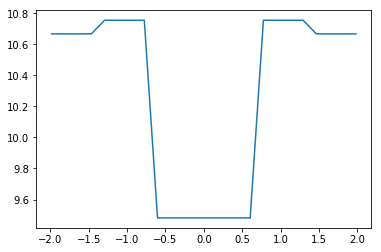

In [8]:
xs = np.linspace(-2.5, 2.5, 30)
qs = [regression_var_criterion(X, y, x) for x in xs]

plt.plot(xs, qs);

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- **Нет**

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

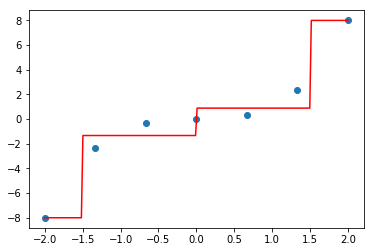

In [9]:
xx = np.linspace(-2, 2, 200)

def prediction(x, X, y):
    if x >= 1.5:
        return np.mean(y[X >= 1.5])
    elif x < 1.5 and x >= 0:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif x >= -1.5 and x < 0:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])
    
    
predictions = [prediction(x, X, y) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y);
plt.plot(xx, predictions, c='red');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **7**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [49]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [50]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [51]:
df['age_years'] = df['age'] / 365.25
df = df.drop(['age'], axis=1)
# df.head()
# df['gluc'].unique()
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,50.357290,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,1,55.381246,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,1,51.627652,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48.249144,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,0,47.841205,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [53]:
X, y = df.drop(['cardio'], axis=1), df['cardio']
# train_test_split?
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=17, test_size=.3)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [60]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [69]:
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=X.columns.values, 
out_file='../../img/small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'

<img src="../../img/small_tree.png">

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **age, ap_hi, chol=3**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [73]:
from sklearn.metrics import accuracy_score
# accuracy_score(clf_tree.predict(X_valid), y_valid)
accuracy_score(y_valid, clf_tree.predict(X_valid))

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [83]:
tree_params = {'max_depth': list(range(2, 11))}

# tree_grid = GridSearchCV # Ваш код здесь
tree_grid = GridSearchCV(clf_tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    4.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    4.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [94]:
tree_grid.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71551, std: 0.00363, params: {'max_depth': 2},
 mean: 0.72771, std: 0.00485, params: {'max_depth': 3},
 mean: 0.73049, std: 0.00453, params: {'max_depth': 4},
 mean: 0.73082, std: 0.00502, params: {'max_depth': 5},
 mean: 0.73155, std: 0.00504, params: {'max_depth': 6},
 mean: 0.73108, std: 0.00304, params: {'max_depth': 7},
 mean: 0.73086, std: 0.00395, params: {'max_depth': 8},
 mean: 0.73002, std: 0.00413, params: {'max_depth': 9},
 mean: 0.72767, std: 0.00405, params: {'max_depth': 10}]

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [91]:
pred = tree_grid.best_estimator_.predict(X_valid)
accuracy_score(y_valid, pred)

0.7263333333333334

In [95]:
for i in range(2, 11):
    clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=17)
    clf_tree.fit(X_train, y_train)
    pred = clf_tree.predict(X_valid)
    print(i, accuracy_score(pred, y_valid))

2 0.7101428571428572
3 0.7212857142857143
4 0.7268571428571429
5 0.7308571428571429
6 0.7263333333333334
7 0.727047619047619
8 0.727
9 0.7279047619047619
10 0.7285238095238096


In [96]:
# (0.7212857142857143 - 0.7263333333333334) / 0.7263333333333334
(0.7263333333333334 - 0.7212857142857143) / 0.7212857142857143 * 100

0.6998085429458022

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- **да, нет**
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- **Верхнее артериальное давление от 140 до 160 (мм рт.ст.)**
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [98]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')
df['age_years'] = df['age'] / 365.25
df = df.drop(['age'], axis=1)

In [99]:
sub_df = df
sub_df['male']  = df.gender - 1

sub_df['age_45_50'] = ((df.age_years >= 45) 
                       & (df.age_years < 50) ).astype('int')
sub_df['age_50_55'] = ((df.age_years >= 50) 
                       & (df.age_years < 55) ).astype('int')
sub_df['age_55_60'] = ((df.age_years >= 55) 
                       & (df.age_years < 60) ).astype('int')
sub_df['age_60_65'] = ((df.age_years >= 60) 
                       & (df.age_years < 65) ).astype('int')

sub_df['ap_hi_120_140'] = ((df.ap_hi >= 120) 
                           & (df.ap_hi < 140)).astype('int')
sub_df['ap_hi_140_160'] = ((df.ap_hi >= 140) 
                           & (df.ap_hi < 160)).astype('int')
sub_df['ap_hi_160_180'] = ((df.ap_hi >= 160) 
                           & (df.ap_hi < 180)).astype('int')

sub_df['chol=1'] = (df.cholesterol == 1).astype('int')
sub_df['chol=2'] = (df.cholesterol == 2).astype('int')
sub_df['chol=3'] = (df.cholesterol == 3).astype('int')

In [115]:
sub_df1 = sub_df.drop(['gluc', 'alco', 'active','gender', 'height', 'weight', 'cholesterol','age_years','ap_hi', 'ap_lo'], axis=1)
X, y = sub_df1.drop(['cardio'], axis=1), sub_df1['cardio']

In [119]:
tree = DecisionTreeClassifier(max_depth=3, 
                              random_state=17).fit(X, y)
export_graphviz(tree, 'mlbootcamp5_dtree2.dot', filled=True, 
                feature_names=X.columns.values)
!dot -Tpng mlbootcamp5_dtree2.dot -o mlbootcamp5_dtree2.png
!rm mlbootcamp5_dtree2.dot

<img src="mlbootcamp5_dtree2.png">